# CSE 519 HW2

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

matplotlib.rcParams['figure.figsize'] = (20,20)

### Loading the dataset and feature exploration

In [12]:
# Load dataset as data matrix X
X = pd.read_csv(open("properties_2016.csv", "rb"))

After loading the dataset we have some inconsistent columns.
Let's try to find which rows are affected and what may be the cause.

In [13]:
inconsistent = [22, 32, 34, 49, 55]

for i in inconsistent:
    print X.keys()[i]

hashottuborspa
propertycountylandusecode
propertyzoningdesc
fireplaceflag
taxdelinquencyflag


It seems to be the case that these features are String typed and NaN has some conflict.
Let's move on for now and examine what our feature space looks like...

In [14]:
print X.shape

(2985217, 58)


In [15]:
for key in X:
    print key

parcelid
airconditioningtypeid
architecturalstyletypeid
basementsqft
bathroomcnt
bedroomcnt
buildingclasstypeid
buildingqualitytypeid
calculatedbathnbr
decktypeid
finishedfloor1squarefeet
calculatedfinishedsquarefeet
finishedsquarefeet12
finishedsquarefeet13
finishedsquarefeet15
finishedsquarefeet50
finishedsquarefeet6
fips
fireplacecnt
fullbathcnt
garagecarcnt
garagetotalsqft
hashottuborspa
heatingorsystemtypeid
latitude
longitude
lotsizesquarefeet
poolcnt
poolsizesum
pooltypeid10
pooltypeid2
pooltypeid7
propertycountylandusecode
propertylandusetypeid
propertyzoningdesc
rawcensustractandblock
regionidcity
regionidcounty
regionidneighborhood
regionidzip
roomcnt
storytypeid
threequarterbathnbr
typeconstructiontypeid
unitcnt
yardbuildingsqft17
yardbuildingsqft26
yearbuilt
numberofstories
fireplaceflag
structuretaxvaluedollarcnt
taxvaluedollarcnt
assessmentyear
landtaxvaluedollarcnt
taxamount
taxdelinquencyflag
taxdelinquencyyear
censustractandblock


It seems that my initial hunch was correct and the mixed type problem stemmed from certain features being String valued.
I will not consider these features for now and only examine numerical data for Pearson correlation.

Next, let's load the training data into a matrix as well and take a look at it's shape.

In [16]:
# Load training data into Y
Y = pd.read_csv(open("train_2016_v2.csv", "rb")).sort_values(by='parcelid')

print Y.shape

(90275, 3)


It seems that we only have a subset of 90275 data points for training.
Let us store a single dataframe with both training and test data for convenience.

In [17]:
training = X.merge(Y, on='parcelid', how='left').dropna(subset=['logerror'])

print training.shape

(90275, 60)


### Pearson Correlation

Now that we have examined the data and isolated our training set we are in a position to run analysis.
First let us run correlation analysis between all non-ID based variables found in the entire training matrix, X.

In [18]:
correlation = X.select(lambda x: not re.search('id', x), axis=1).corr(method='pearson')

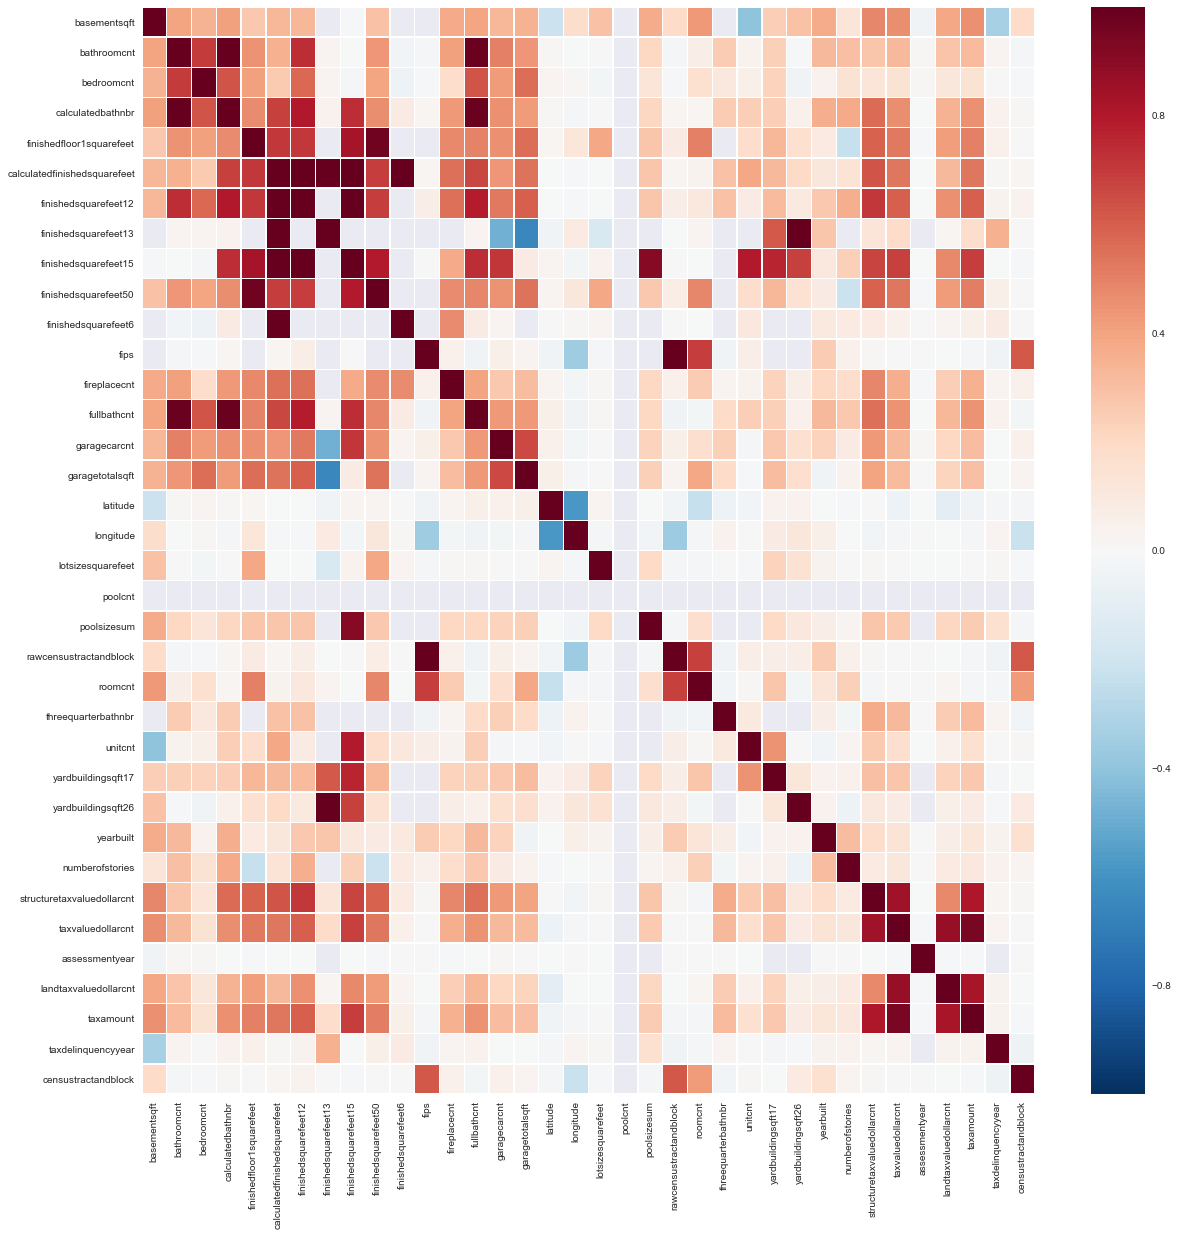

In [19]:
sns.heatmap(correlation, linewidths=.5)
sns.plt.show()

From visual observation of the data we can note some interesting correlations.

Some of the strongest positve correlations include:
- bathroomcnt and bedroomcnt
- bathroomcnt and finishedfloor1squarefeet
- bathroomcnt and fullbathcnt
- structuretaxvaluedollarcnt and taxvalueddollarcnt

There are many more strong correlations as shown in the plot, however most of them are uninteresting as they are renamings or different metrics of similar things (such as square feetage).  The last two examples I listed above are in this uninteresting category.

Some of the strongest negative correlations include:
- garagetotalsqft and finishedsquarefeet13
- garagecarcnt and finishedsquarefeet13
- longitude and latitude
- basementsqft and unitcnt

There were generally far fewer negative correlations in the data, but they are more interesting as they reveal relationships which are not based on similar information.

### 5 Interesting Plots

#### Pearson Correlation with log error

Let's examine how correlated each individual numerical feature is with the log error.  Again, we should not include the results computed using ID fields in the correlation analysis.  However, now we will only consider the constructed training dataframe which only includes samples with recorded logerrors.

In [36]:
error_correlation = training.corr(method='pearson')['logerror'][:-1].select(lambda x: not re.search('id', x))

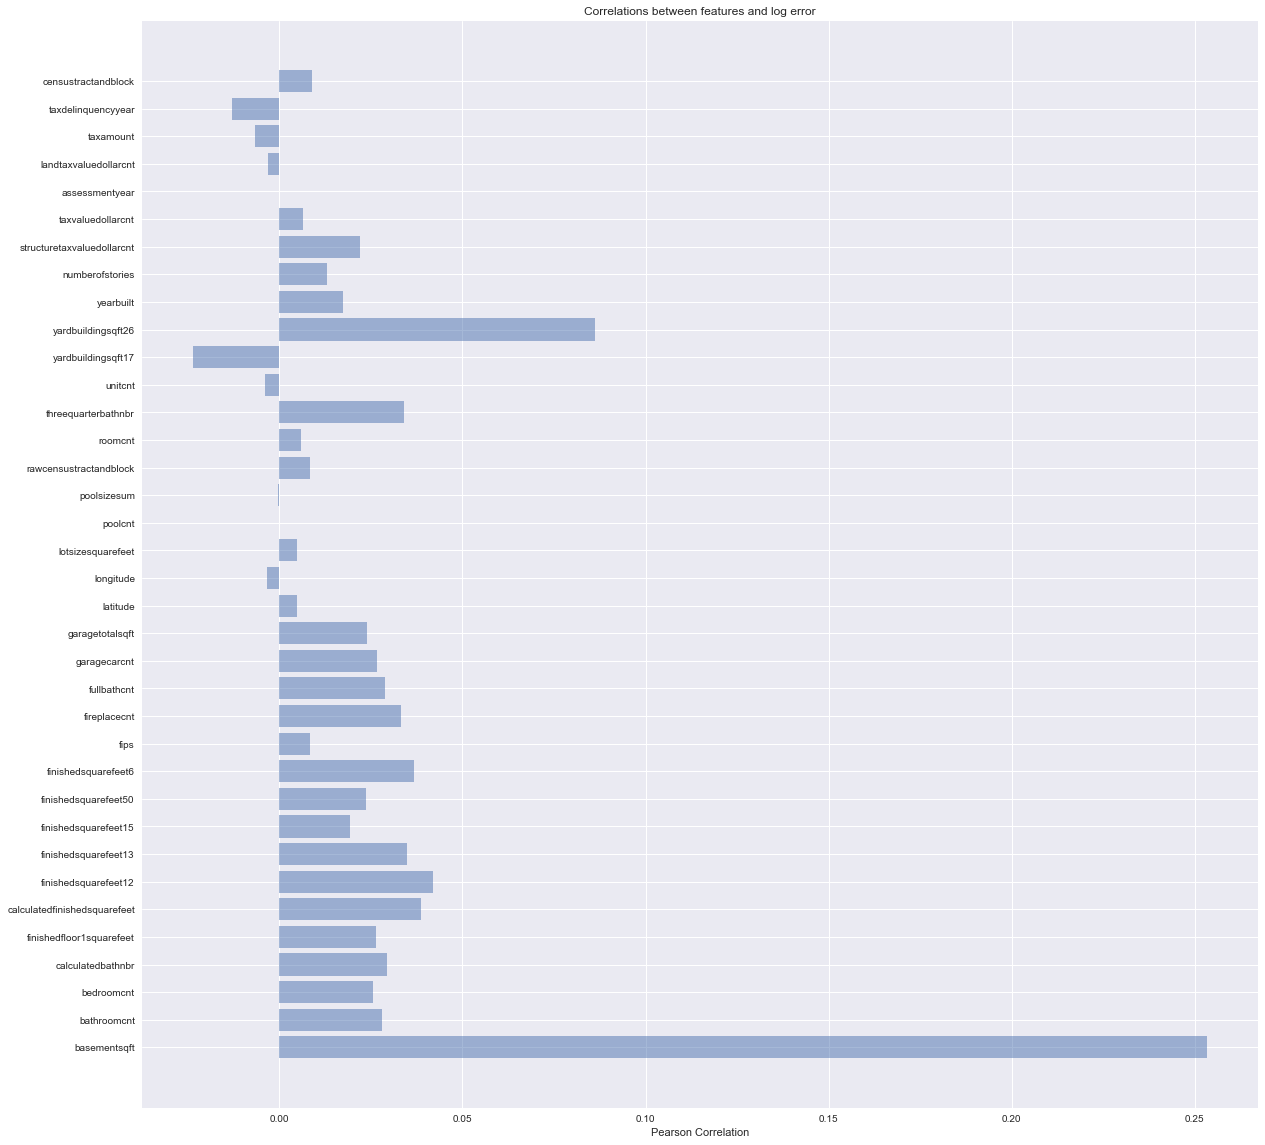

In [35]:
y_pos = np.arange(len(error_correlation.values))
plt.barh(y_pos, error_correlation.values, align='center', alpha=0.5)
plt.yticks(y_pos, error_correlation.index)
plt.xlabel('Pearson Correlation')
plt.title('Correlations between features and log error')
plt.show()

A quick scan of the remaining entries shows relatively low correlation between any of the values and the log error.  
Interestingly, basementsqft has much higher correlation coefficient than any other field.  This analysis seems to indicate that there is no single feature which correlates strongly as a linear function with the Zillow log error.

This is to be expected since we can only assume that Zillow is using a more sophisticated model to estimate the housing prices.  Also, as there are many economic and other such factors which play a role in the price of a house, this is certainly not a space which can be easily solved with a simple correlation of a single feature.

#### Spearman Correlation with log error

Although there may not be a linear relationship between any pair of (feature, logerror) it may be the case that they are correlated in another fashion.  Let's run Spearman correlation and see if this is the case.

In [37]:
s_error_correlation = training.corr(method='spearman')['logerror'][:-1].select(lambda x: not re.search('id', x))

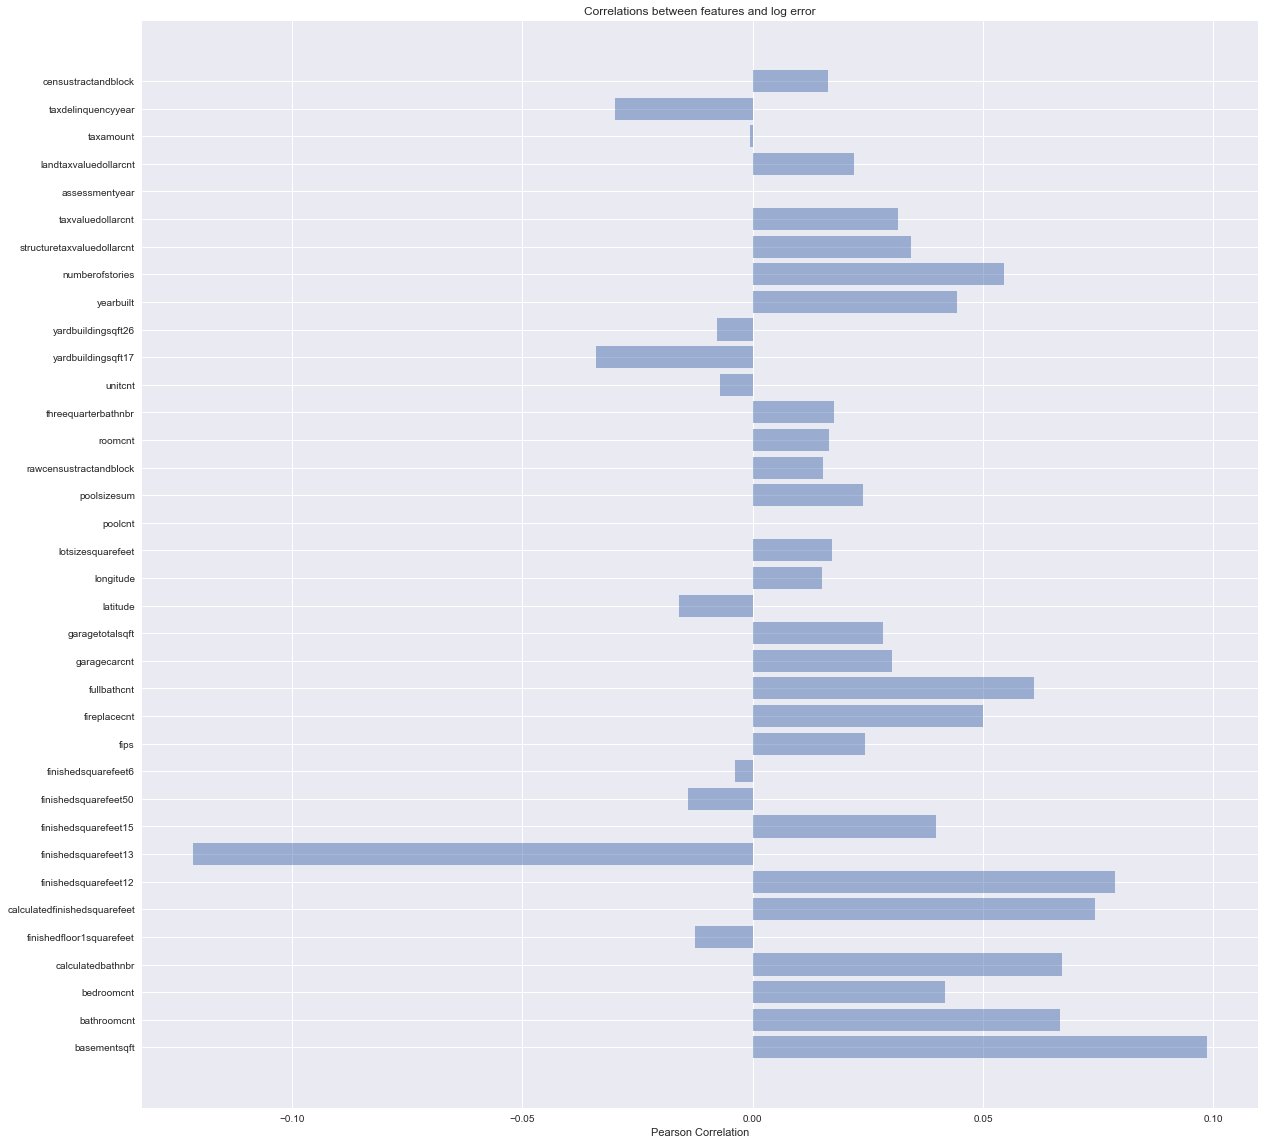

In [38]:
y_pos = np.arange(len(s_error_correlation.values))
plt.barh(y_pos, s_error_correlation.values, align='center', alpha=0.5)
plt.yticks(y_pos, s_error_correlation.index)
plt.xlabel('Pearson Correlation')
plt.title('Correlations between features and log error')
plt.show()

The Spearman correlation has a much different distribution than Pearson.  We see many more pronounced negative correlations in the data.  Also the outlier of basementsqft has been smoothed, although it still has the strongest positive correlation with the log error.

We still have the same observation from Pearson however.  No one feature contributes a significant amount to the variation in the log error.  We will have to try harder in our models to capture the functional relationships.